In [1]:
# Imports we need.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx

%matplotlib inline  

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Entry Point [tensor2tensor.envs.tic_tac_toe_env:TicTacToeEnv] registered with id [T2TEnv-TicTacToeEnv-v0]


In [2]:
data_dir='../data/algorithmic_count100'
tmp_dir='../tmp/algorithmic_count100'

# Fetch the problem
problem = problems.problem("algorithmic_count100")
# The generate_data method of a problem will download data and process it into
# a standard format ready for training and evaluation.
problem.generate_data(data_dir, tmp_dir)

# Get the encoders from the problem
encoders = problem.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None, mode="inputs"):
  """Input str to features dict, ready for inference"""
  inputs = encoders[mode].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers, mode="inputs"):
  """List of ints to str"""
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders[mode].decode(np.squeeze(integers))



INFO:tensorflow:Skipping generator because outputs files exists at ['../data/algorithmic_count100/algorithmic_count100-train-00000-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00001-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00002-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00003-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00004-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00005-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00006-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00007-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00008-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00009-of-00010']
INFO:tensorflow:Skipping generator because outputs files exists at ['../data/algorithmic_count100/algorithmic_count100-dev-00000-of-00001']


In [15]:
#@title Create the model
# Create hparams and the model
model_name = "bottomup_transformer_encoder"
hparams_set = "bottomup_transformer_tiny_tune"

hparams = trainer_lib.create_hparams(hparams_set, data_dir=data_dir, problem_name="algorithmic_count100")
# hparams.assignment_softmax_temp = 1.0
# hparams.assignment_softmax_temp_decay_rate = 0.5

# hparams.use_gumbel = True
# hparams.reset_presence_q = True
# hparams.scale_weights_with_presenc_k= True
# hparams.update_presence = True
# hparams.presence_softmax_temp = 1.0
# hparams.presence_softmax_temp_decay_rate = 0.5
# hparams.num_heads = 2
# hparams.transform_presence_logits = False
# NOTE: Only create the model once when restoring from a checkpoint; it's a
# Layer and so subsequent instantiations will have different variable scopes
# that will not match the checkpoint.


In [16]:
#@title Utility functions
from tensor2tensor.visualization import attention
from tensor2tensor.data_generators import text_encoder

SIZE = 35

def encode_eval(input_str, output_str):
  inputs = tf.reshape(encoders["inputs"].encode(input_str) + [1], [1, -1, 1, 1])  # Make it 3D.
  outputs = tf.reshape(encoders["inputs"].encode(output_str) + [1], [1, -1, 1, 1])  # Make it 3D.
  return {"inputs": inputs, "targets": outputs}

def get_att_mats(model):
  assignment_weights = []
  weights = []
  presence_qz = []
  presence_qz_logits = []
  similarieties = []
  q_presence_mats = []
  k_presence_mats = []
  softmax_temps = []


  for i in range(hparams.num_hidden_layers):
    assignment_weight = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/assignment_weights" % i]
    weight = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/weights" % i]
    presence_q = None
    # model.attention_weights["bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/q_presence_probs" % i]
    presence_q_logit = None
    #model.attention_weights["bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/q_presence_logits" % i]
    
    q_presence_mat = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/q_presence_mat" % i]

    k_presence_mat = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/k_presence_mat" % i]

    similarity = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/similarities" % i]

    softmax_temp = model.attention_weights[
      "bottomup_transformer_encoder/body/encoder/layer_%i/self_attention/multihead_attention/bottom_up_dot_product_attention/softmax_tmp" % i]

        
    assignment_weights.append(assignment_weight)
    weights.append(weight)
    presence_qz.append(presence_q)
    presence_qz_logits.append(presence_q_logit)
    similarieties.append(similarity)
    q_presence_mats.append(q_presence_mat)
    k_presence_mats.append(k_presence_mat)
    softmax_temps.append(softmax_temp)

  return np.asarray(assignment_weights), \
        np.asarray(weights), \
        np.asarray(presence_qz), \
        np.asarray(presence_qz_logits), \
        np.asarray(similarieties), \
        np.asarray(q_presence_mats), np.asarray(k_presence_mats), softmax_temps

def resize(np_mat):
  # Sum across heads
  np_mat = np_mat[:, :SIZE, :SIZE]
  row_sums = np.sum(np_mat, axis=0)
  # Normalize
  layer_mat = np_mat / row_sums[np.newaxis, :]
  lsh = layer_mat.shape
  # Add extra dim for viz code to work.
  layer_mat = np.reshape(layer_mat, (1, lsh[0], lsh[1], lsh[2]))
  return layer_mat

def to_tokens(ids):
  ids = np.squeeze(ids)
  subtokenizer = hparams.problem_hparams.vocabulary['targets']
  tokens = []
  for _id in ids:
    if _id == 0:
      tokens.append('<PAD>')
    elif _id == 1:
      tokens.append('<EOS>')
    elif _id == -1:
      tokens.append('<NULL>')
    else:
        tokens.append(subtokenizer._subtoken_id_to_subtoken_string(_id))
  return tokens

def plot_mat_per_layer(attention_mat):
    cmap = plt.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    for layer in np.arange(len(attention_mat)):
      print("Layer number: %d" %layer)
      axes = {}
      f = plt.figure(figsize=(10,3))
      for head in np.arange(1,len(attention_mat[layer][0])+1):
        axes[head] = f.add_subplot(1,len(attention_mat[layer][0]),head)
        im = axes[head].imshow(attention_mat[layer][0][head-1],cmap=cmap, norm=norm)
        axes[head].get_xaxis().set_visible(False)
        axes[head].get_yaxis().set_visible(False)
        plt.colorbar(im)  
      plt.show()

In [17]:
#@title Classify an example and get the attention mats
# Restore and translate!
ckpt_path = '../logs/algorithmic_count100/bottomup_transformer_encoder_bottomup_transformer_tiny_tune_trial1/'
ckpt_path = tf.train.latest_checkpoint(ckpt_path)
print(ckpt_path)
def classify(inputs):
  encoded_inputs = encode(inputs)
  with tfe.restore_variables_on_create(ckpt_path):
   model_output = model.infer(encoded_inputs)["logits"]
  return np.argmax(model_output)

def classify_examples(examples_inputs):
  with tfe.restore_variables_on_create(ckpt_path):
      model_output = model.infer(examples_inputs)
  return model_output.numpy()

../logs/algorithmic_count100/bottomup_transformer_encoder_bottomup_transformer_tiny_tune_trial1/model.ckpt-250000


In [105]:
tf.reset_default_graph()
model = registry.model(model_name)(hparams, Modes.EVAL)
inputs = " 5 1 1 1 2 2 2 3 3 3 1 1 1 1 1 1 5 5 5 5"
outputs = classify(inputs)

print("Inputs: %s" % inputs)
print("Outputs: %s" % outputs)

Inputs:  5 1 1 1 2 2 2 3 3 3 1 1 1 1 1 1 5 5 5 5
Outputs: 3


In [103]:
with tfe.restore_variables_on_create(ckpt_path):
    encoded_inputs = encode(inputs)
    model_output = model.infer(encoded_inputs)
    assignment_weights, weights , presence_qz, presence_qz_logits, similarieties, q_presence_mats, k_presence_mats, softmax_temps = get_att_mats(model)

Layer number: 0


<Figure size 432x288 with 0 Axes>

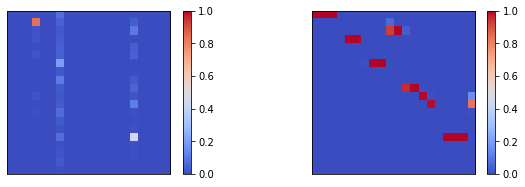

Layer number: 1


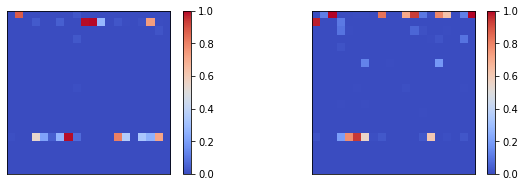

In [99]:
#@title Encoder attention at different layers
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plot_mat_per_layer(assignment_weights)

Layer number: 0


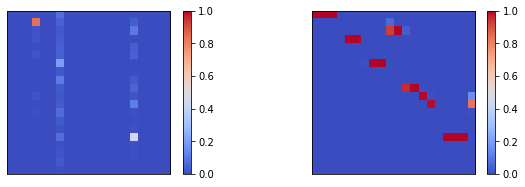

Layer number: 1


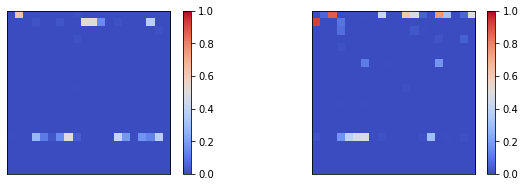

In [100]:
plot_mat_per_layer(weights)

Layer number: 0


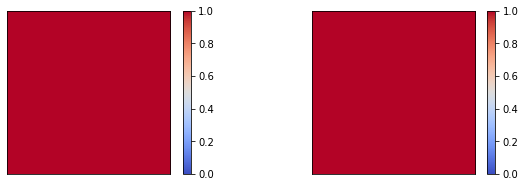

Layer number: 1


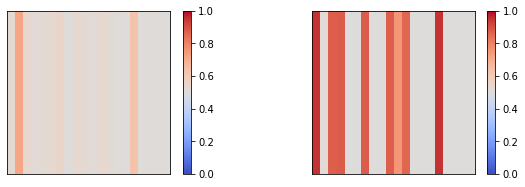

In [101]:
plot_mat_per_layer(k_presence_mats)

In [61]:
# Setup the training data
BATCH_SIZE = 1
train_dataset = problem.dataset(Modes.EVAL, data_dir)
train_dataset = train_dataset.padded_batch(batch_size=BATCH_SIZE, padded_shapes={'inputs':[None], 'targets':[1], 'batch_prediction_key':[None]})
train_dataset = train_dataset.repeat(None)

examples = tfe.Iterator(train_dataset).next()
classify(decode(examples['inputs']))


INFO:tensorflow:Reading data files from ../data/algorithmic_count100/algorithmic_count100-dev*
INFO:tensorflow:partition: 0 num_data_files: 1


17

In [62]:
assignment_weights, weights , presence_qz, presence_qz_logits, similarieties, q_presence_mats, k_presence_mats = get_att_mats(model)

ValueError: too many values to unpack (expected 7)

In [ ]:
for layer in np.arange(len(presence_qz[:,0])):
    n, bins, patches = plt.hist(presence_qz[layer,0], 10, density=True, facecolor='g', alpha=0.75)
    plt.show()

In [ ]:
X = csr_matrix([[0, 8, 0, 3],
                 [0, 0, 2, 5],
                 [0, 0, 0, 6],
                 [0, 0, 0, 0]])
Tcsr = minimum_spanning_tree(X)

Tcsr.toarray()

G = nx.from_numpy_matrix(np.array(Tcsr.toarray())) 
nx.draw(G, with_labels=True)

In [ ]:
print(weights[0][0][0].shape)
G = nx.from_numpy_matrix(np.array(weights[0][0][0])) 
nx.draw(G, with_labels=True)

In [ ]:
from networkx.algorithms import bipartite

B = nx.Graph()
B.add_nodes_from(np.arange(len(weights[0][0][0])), bipartite=0)
B.add_nodes_from(np.arange(len(weights[0][0][0])), bipartite=1)
#B.add_edges_from(weights[0][0][0])

plt.figure()
edges = B.edges()
print(edges)
X, Y = bipartite.sets(B)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw_networkx(B, pos=pos, edges=edges)
plt.show()

In [11]:
softmax_temps

[0.01, 0.005, 0.0033333333333333335, 0.0025]

AttributeError: 'NoneType' object has no attribute 'shape'